## Making the plot of the paper


In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import astropy.time
import torch
import pandas as pd
import math
from sdo.datasets.degradation_sdo_dataset import DegradationSDO_Dataset
from sdo.pytorch_utilities import create_dataloader
from sdo.models.autocalibration_models import Autocalibration6, Autocalibration10
from astropy.visualization import time_support
from scipy.stats import ks_2samp
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

## Setting some variables

In [2]:
data_basedir = '/Users/lguedesd/Documents/Research/FDL Data/'
data_inventory = '/Users/lguedesd/Documents/Research/FDL Data/inventory_local_new.pkl'
results_path = '/Users/lguedesd/Documents/Research/FDL Data/Results/'
experiment_name = 'luiz_exp_36_apodize'
instr = ['AIA','AIA','AIA','AIA','AIA','AIA','AIA']
channels = ['0094','0131','0171','0193','0211','0304','0335']
channels_names = ['$94~\AA$','$131~\AA$','$171~\AA$','$193~\AA$','$211~\AA$','$304~\AA$','$335~\AA$']

## Loading the SDO data and making predictions using the Multi-Channel model

### It has two outputs: Seven degradation values "degradation_multi_channel" for all channels and seven dates "dates_multi_channel"

In [3]:
model_file = 'luiz_exp_36_apodize_model.pth'
# model_file = '1000_luiz_exp_36_apodize_max_alpha_relu6_model.pth'


test_dataset = DegradationSDO_Dataset(data_basedir = data_basedir,
                                    data_inventory = data_inventory,
                                    instr = instr,
                                    channels = channels,
                                    yr_range = [2010,2020],
                                    mnt_step = 1,
                                    day_step = 7,
                                    h_step = 1,
                                    min_step = 1,
                                    resolution = 512,
                                    subsample = 2,
                                    normalization = 0, 
                                    scaling = True,
                                    apodize = True,
                                    shuffle = False,
                                    holdout = False,
                                    test_ratio = 1,
                                    test = True)

test_loader = create_dataloader(test_dataset, batch_size=128, num_dataloader_workers=8, shuffle=False, train=True)

model = Autocalibration6(input_shape=[7, 256, 256], output_dim=7)
model.load_state_dict(torch.load(data_basedir+'Models/'+model_file,map_location=torch.device('cpu')))

final_predictions = []
with torch.no_grad():
    for batch_idx, (input_data, dates) in enumerate(test_loader):
        if batch_idx==0:
            output = model(input_data)
            temp_degradation_multi = output
            dates_multi_channel_array = np.array(dates)
        else:
            output = model(input_data)
            temp_degradation_multi = torch.cat((temp_degradation_multi, output), 0)
            dates_multi_channel_array = np.append(dates_multi_channel_array,dates,axis=0) 

degradation_multi_channel = temp_degradation_multi.detach().numpy()

# Loading the SDO data and making predictions using the Single-Channel model

### It has two outputs: Seven degradation values "single_degradation_total" for all channels (this was ran in a loop, each time for one channel" and seven dates "dates_multi"

In [4]:
degradation_single_channel = []
dates_single_channel_array = []
model_file = ['1000_luiz_exp_33_0094_masked_model.pth',\
              '1000_luiz_exp_33_0131_masked_model.pth',\
              '1000_luiz_exp_33_0171_masked_model.pth',\
              '1000_luiz_exp_33_0193_masked_model.pth',\
              '1000_luiz_exp_33_0211_masked_model.pth',\
              '1000_luiz_exp_33_0304_masked_model.pth',\
              '1000_luiz_exp_33_0335_masked_model.pth']

for c in range(len(channels)):
    test_dataset = DegradationSDO_Dataset(data_basedir = data_basedir,
                                data_inventory = data_inventory,
                                instr = [instr[c]],
                                channels = [channels[c]],
                                yr_range = [2010,2020],
                                mnt_step = 1,
                                day_step = 7,
                                h_step = 1,
                                min_step = 1,
                                resolution = 512,
                                subsample = 2,
                                normalization = 0, 
                                scaling = True,
                                apodize = True,
                                shuffle = False,
                                holdout = False,
                                test_ratio = 1,
                                test = True)


    test_loader = create_dataloader(test_dataset, batch_size=128, num_dataloader_workers=8, shuffle=False, train=False)

    model = Autocalibration6(input_shape=[1, 256, 256], output_dim=1)
    model.load_state_dict(torch.load(data_basedir+'models/'+model_file[c],map_location=torch.device('cpu')))

    final_predictions = []
    with torch.no_grad():
        for batch_idx, (input_data, dates) in enumerate(test_loader):
            if batch_idx==0:
                output = model(input_data)
                temp_degradation_single = output
                temp_dates_single = np.array(dates)
            else:
                output = model(input_data)
                temp_degradation_single = torch.cat((temp_degradation_single, output), 0)
                temp_dates_single = np.append(temp_dates_single,dates,axis=0) 

    temp_degradation_single = temp_degradation_single.detach().numpy()
    degradation_single_channel.append(temp_degradation_single)
    dates_single_channel_array.append(temp_dates_single)

## Converting all times to astropy time.

In [5]:
eve_date = ['20140526','20140526'] #Last date with EVE MEGS-A data.
last_training_date = ['20131231','20131231'] #Last date with EVE MEGS-A data.
xticks = ['20100101','20110101','20120101','20130101','20140101','20150101','20160101','20170101','20180101','20190101','20200101',]

dates_multi_channel_str = list(map('{:4d}{:02d}{:02d}{:02d}{:02d}'.format,dates_multi_channel_array[:,0],dates_multi_channel_array[:,1],dates_multi_channel_array[:,2],dates_multi_channel_array[:,3],dates_multi_channel_array[:,4]))

dates_multi = [datetime.datetime.strptime(i,"%Y%m%d%H%M").date() for i in dates_multi_channel_str]
dates_multi = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in dates_multi])

eve_line = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in eve_date]
eve_line = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in eve_line])

last_training_line = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in last_training_date]
last_training_line = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in last_training_line])

xticks = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in xticks]
xticks = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in xticks])

dates_single=[]
for c in range(len(channels)):
    dates_single_channel_str = list(map('{:4d}{:02d}{:02d}'.format,dates_single_channel_array[c][:,0],dates_single_channel_array[c][:,1],dates_single_channel_array[c][:,2]))
    temp = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in dates_single_channel_str] #x_values for 0094
    temp = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in temp])
    dates_single.append(temp)

## Definig two fuctions to use as a median filter

In [6]:
def date_median(dates):
    median = math.floor(np.median(dates.astype('int64')))
    result = np.datetime64(median, "ns") #unit: nanosecond
    return result

def moving_median(data,dates,window):
    iti = int(np.floor(data.shape[0]/window))
    median = []
    date = []
    
    for i in range(iti-1):
        median.append(np.median(data[(i*window):((i+1)*window)]))
        date.append(date_median(dates[(i*window):((i+1)*window)]))
        
    return np.array(median, dtype='float64'), pd.to_datetime(date)

def moving_std(data,dates,window):
    iti = int(np.floor(data.shape[0]/window))
    std = []    

    for i in range(iti):
        std.append(np.std(data[(i*window):((i+1)*window)]))
                
    return np.array(std, dtype='float64')

## Plotting the Degradation Curve

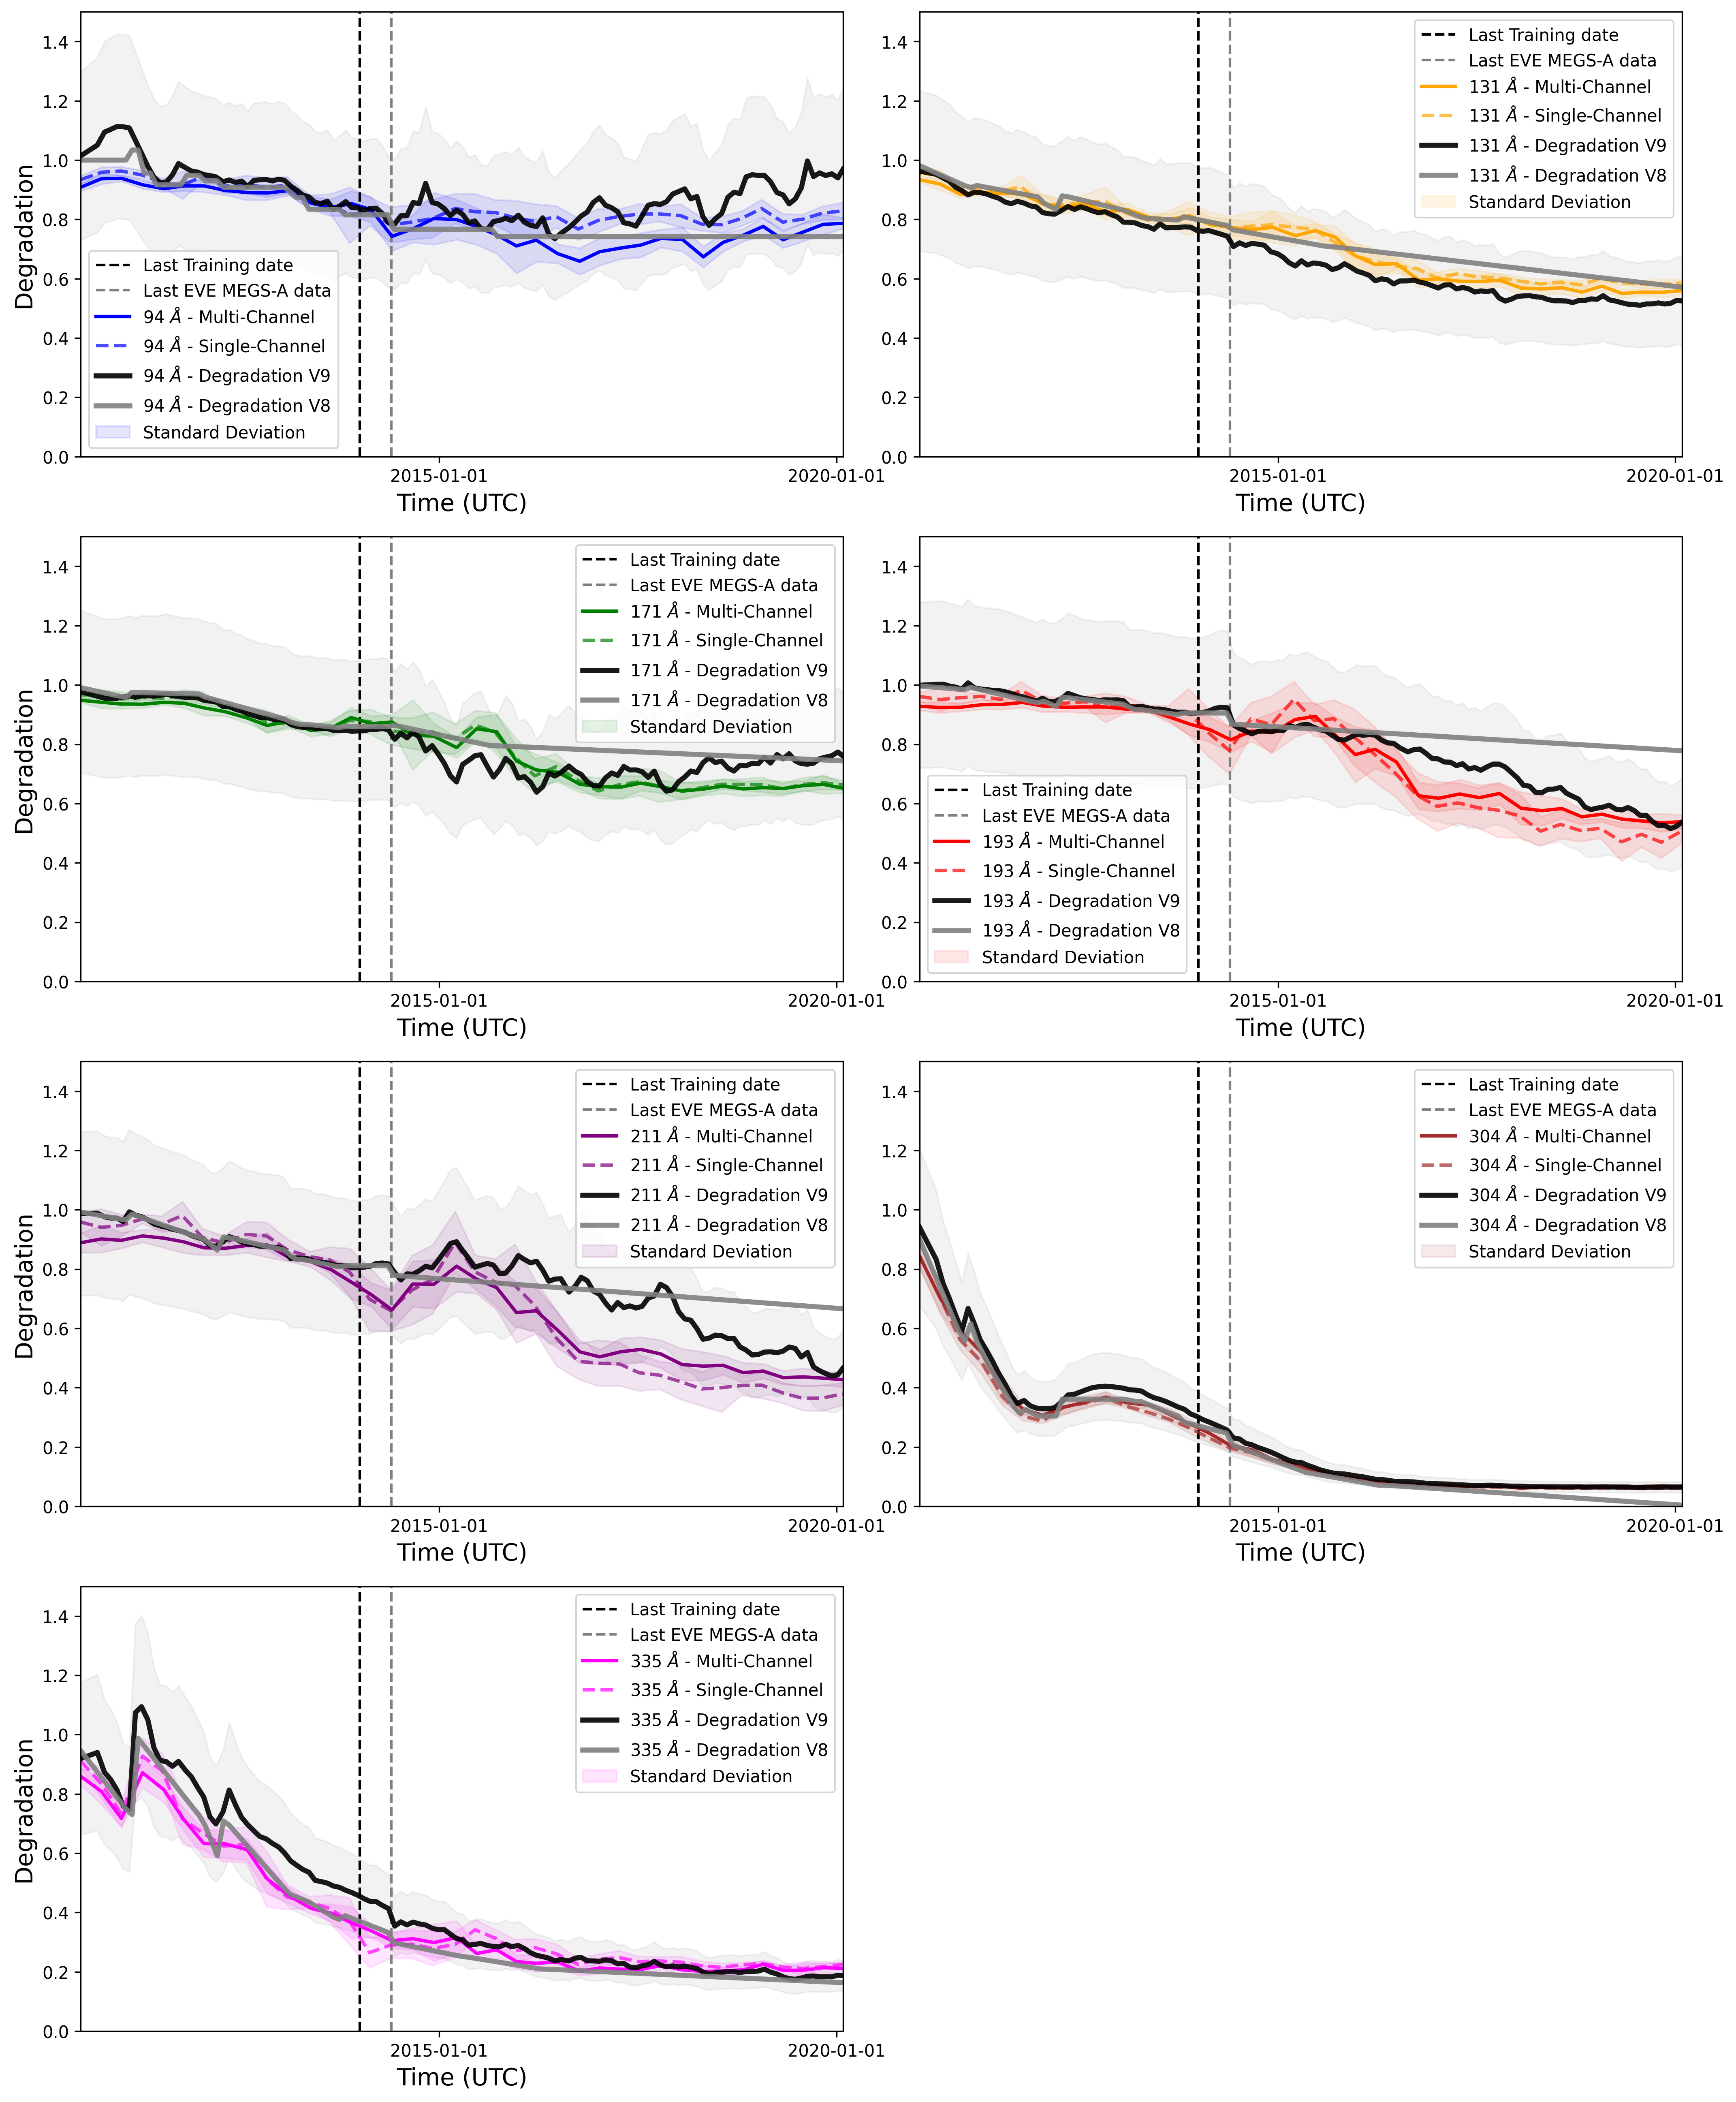

In [7]:
save = False #Save the plot or not.

v9dat = pd.read_csv('/Users/lguedesd/Downloads/euv_ratios.csv', parse_dates=True,
                    names=["DATE"] + channels, index_col="DATE",skiprows=1, header=0) #Reading the degradations obtained from AIApy for curve V9
v8dat = pd.read_csv('/Users/lguedesd/Downloads/v8table.csv', parse_dates=True,
                    names=["DATE"] + channels) #Reading the degradations obtained from AIApy for curve V8
v8dat['DATE'].replace('Z', '.000',regex=True,inplace=True) #Fixing some inconsistent data formating
v8dat['DATE'] = pd.to_datetime(v8dat['DATE'], infer_datetime_format=True)
v8dat.set_index('DATE', inplace=True)

time_support()  #Adding support of Astropy date to plot.
colors = ['Blue','Orange','Green','Red','Purple','Brown','Magenta']

fig, ax = plt.subplots(4, 2, figsize=(17,22), dpi=300)
fig.subplots_adjust(wspace=0.1,hspace=0.18)
ax = ax.ravel()    

for c in range(len(channels)):
    v9dat[channels[c]] = v9dat[channels[c]].astype(np.float64)
    v8dat[channels[c]] = v8dat[channels[c]].astype(np.float64)

    v9dat[channels[c]] = v9dat[channels[c]]/v9dat[channels[c]][0]
    v8dat[channels[c]] = v8dat[channels[c]]/v8dat[channels[c]][0]
    v9med_data, v9med_dates = moving_median(v9dat[channels[c]],v9dat.index,28)
    v8med_data, v8med_dates = moving_median(v8dat[channels[c]],v8dat.index,28)

    multi_med_data, multi_med_dates = moving_median(degradation_multi_channel[:,c],pd.DataFrame(dates_multi.tt.datetime),15)
    multi_std_data = moving_std(degradation_multi_channel[:,c],pd.DataFrame(dates_multi.tt.datetime),15)
    single_med_data, single_med_dates = moving_median(degradation_single_channel[c],pd.DataFrame(dates_single[c].tt.datetime),15)
    single_std_data = moving_std(degradation_single_channel[c],pd.DataFrame(dates_single[c].tt.datetime),15)
    
    euv_v9_times = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in v9med_dates])
    euv_v8_times = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in v8med_dates])
    multi_med_times = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in multi_med_dates])
    single_med_times = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in single_med_dates])


    # ax[c].fill_between(dates_multi[0:209],1.5,0,color=colors[c],label='Training data period', alpha=0.05)
    ax[c].plot(last_training_line,[0,2], '--', color='black', label='Last Training date')
    ax[c].plot(eve_line,[0,2], '--', color='gray', label='Last EVE MEGS-A data')
    ax[c].plot(multi_med_times, multi_med_data, \
               label=channels_names[c]+' - Multi-Channel',linewidth=2,color=colors[c])
    ax[c].plot(single_med_times, single_med_data,'--',\
               label=channels_names[c]+' - Single-Channel', linewidth=2,color=colors[c], alpha=0.7)
    ax[c].plot(euv_v9_times, v9med_data, color='black',\
               label=channels_names[c]+' - Degradation V9', linewidth=3, alpha=0.9)
    ax[c].plot(euv_v8_times, v8med_data, color='gray',\
               label=channels_names[c]+' - Degradation V8', linewidth=3, alpha=0.9)
    
    up = [m + n for m, n in zip(v9med_data, v9med_data*0.28)]
    up_multi = [m + n for m,n in zip(multi_med_data,multi_std_data)]
    up_single = [m + n for m,n in zip(single_med_data,single_std_data)]
    down = [m - n for m, n in zip(v9med_data,v9med_data*0.28)]
    down_multi = [m - n for m,n in zip(multi_med_data,multi_std_data)]
    down_single = [m - n for m,n in zip(single_med_data,single_std_data)]

    ax[c].fill_between(euv_v9_times,up,down,color='gray', alpha=0.1)
    ax[c].fill_between(multi_med_times,up_multi,down_multi,color=colors[c], label='Standard Deviation', alpha=0.1)
    ax[c].fill_between(single_med_times,up_single,down_single,color=colors[c], alpha=0.1)


    if c%2 == 0:
        ax[c].set_ylabel('Degradation',fontsize=14)
    ax[c].set_xlabel('Time (UTC)',fontsize=14)
    plt.xticks(np.arange(0,10),fontsize=14)
    plt.yticks(fontsize=14)
    ax[c].legend(fontsize=10)
#     plt.title('DNN-retrieved EUV degradation factors', fontsize=15)
    ax[c].set_ylim(0,1.5)
    ax[c].set_xlim(multi_med_times[0]-1,multi_med_times[-1])

ax[c+1].set_visible(False)

if save:
    plt.savefig(results_path+experiment_name+'_Degradation.pdf', bbox_inches='tight',dpi=1000)
    plt.close()


In [8]:
for c in range(0,len(channels)):
    v9med_data, v9med_dates = moving_median(v9dat[channels[c]],v9dat.index,28)

    multi_med_data, multi_med_dates = moving_median(degradation_multi_channel[:,c],pd.DataFrame(dates_multi.tt.datetime),15)

    print('Channel: '+channels[c])
    distance, path = fastdtw(multi_med_data, v9med_data, dist=euclidean)
    KS = ks_2samp(multi_med_data, v9med_data)
    print(distance)  
    print(KS)
print()
print()
print()
for c in range(0,len(channels)):
    v9med_data, v9med_dates = moving_median(v9dat[channels[c]],v9dat.index,28)

    single_med_data, single_med_dates = moving_median(degradation_single_channel[c],pd.DataFrame(dates_single[c].tt.datetime),15)

    print('Channel: '+channels[c])
    distance, path = fastdtw(single_med_data, v9med_data, dist=euclidean)
    KS = ks_2samp(single_med_data, v9med_data)
    print(distance) 
    print(KS)
print()
print()
print()    
for c in range(0,len(channels)):

    multi_med_data, multi_med_dates = moving_median(degradation_multi_channel[:,c],pd.DataFrame(dates_multi.tt.datetime),15)
    single_med_data, single_med_dates = moving_median(degradation_single_channel[c],pd.DataFrame(dates_single[c].tt.datetime),15)

    print('Channel: '+channels[c])
    distance, path = fastdtw(multi_med_data, single_med_data, dist=euclidean)
    KS = ks_2samp(multi_med_data, single_med_data)
    print(distance) 
    print(KS)

Channel: 0094
7.576813911722214
KstestResult(statistic=0.4573934837092732, pvalue=4.447846354449503e-06)
Channel: 0131
1.5919602889859066
KstestResult(statistic=0.2698412698412698, pvalue=0.02241632163609575)
Channel: 0171
3.3751310580421485
KstestResult(statistic=0.3128654970760234, pvalue=0.004863823882144014)
Channel: 0193
2.0135374501679837
KstestResult(statistic=0.25396825396825395, pvalue=0.03726517103706817)
Channel: 0211
2.7618540874202937
KstestResult(statistic=0.2322472848788638, pvalue=0.07099675917951109)
Channel: 0304
1.2146842153192399
KstestResult(statistic=0.10401002506265664, pvalue=0.8715718259036788)
Channel: 0335
2.534098048330279
KstestResult(statistic=0.1984126984126984, pvalue=0.1722372558542471)



Channel: 0094
4.7586219142501545
KstestResult(statistic=0.3404344193817878, pvalue=0.001597310391497464)
Channel: 0131
2.6734720581884117
KstestResult(statistic=0.35714285714285715, pvalue=0.0007679870468179084)
Channel: 0171
2.886085301689599
KstestResult(statistic=0